In [25]:
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy.integrate import solve_bvp


In [12]:
# Import from stablab
from stablab import Evans_compute, winding_number, Evans_plot, emcset, Struct
from stablab.contour import semicirc, semicirc2
from stablab.evans import Aadj
from stablab.periodic_contour import periodic_contour
from stablab.wave_profile import deval, soln
from stablab.root_finding import moments_roots

In [13]:
# Import KS-specific functions
from ks_guess import ks_guess
from ks_profile2 import ks_profile2
from ks_taylor import ks_taylor

In [14]:
# Import several other KS functions
from KS import A, f, ks_profile, bc, periodic_ode, interpolate

In [15]:
# Declare the dictionary p.
p = Struct()
p.X = 6.3
p.epsilon = 0
p.delta = 1
p.q = 5.5

# Compute Profile

In [16]:
# Declare the dictionaries s and d
s = Struct()
d = Struct()
s.something = 1

# find profile solution
s.sol, p.delta = ks_profile(s,p)
d.s = s # record parameters in data structure d
d.p = p # record parameters in data structure d

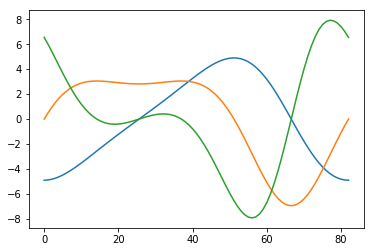

In [18]:
# Plot the profile solution
plt.plot(s.sol.y[0])
plt.plot(s.sol.y[1])
plt.plot(s.sol.y[2])
plt.show()

# Evans function computations

In [20]:
# Find the L infinity norm of the profile u and u'
x = np.linspace(0,p.X,1000)
temp = s.sol.sol(x)
Linf_bar_u = max(np.abs(temp[0,:]))
Linf_bar_u_prime = max(np.abs(temp[1,:]))

In [21]:
# record the L infinity norms in the data structure
d.Linf_bar_u = Linf_bar_u
d.Linf_bar_u_prime = Linf_bar_u_prime

In [28]:
# STABLAB structuress
s.X = p.X
# s,e,m,c = emcset(s,'periodic',[2,2],'balanced_polar_periodic',A)
s,e,m,c = emcset(s,'periodic',[2,2],'balanced_polar_scaled_periodic',A)
# s,e,m,c = emcset(s,'periodic',[2,2],'regular_periodic',A)
c.ksteps = 100000
c.refine = 'on'
c.stats = 'print'
m['options']['nsteps'] = 500 # max steps between each iteration of the ODE solver

In [23]:
# Determine the HF bound and record it.
R = 0.5*(Linf_bar_u_prime+Linf_bar_u**2+p.delta**2+0.5*(1+2*p.epsilon**2)**2)
R1 = max(R+0.1,2)
R2 = 1
d.R = R
d.R1 = R1
d.R2 = R2

In [24]:
kappa = np.linspace(-np.pi/p.X,np.pi/p.X,1000);
circpnts = 10; imagpnts = 10; innerpnts = 5; spread = 4;
# circpnts=50; imagpnts=50; innerpnts=20; spread=4;
preimage = semicirc2(circpnts,imagpnts,innerpnts,c.ksteps,R1,spread,R2)
preimage = np.concatenate((preimage[0:-1], np.flipud(np.conj(preimage))))

### Compute the Evans function for HF study

In [29]:
startTime = time.time()
D, preimage2 = periodic_contour(kappa,preimage,c,s,p,m,e)
totTime = time.time() - startTime


Relative Error:  1.8117948041395266

Relative Error:  0.7130439489572146

Relative Error:  0.31832565906187166

Relative Error:  0.1991364016041226


In [30]:
# HF study output and statistics
d.D1 = Struct()
d.D1.time = totTime
d.D1.points = len(preimage2)
d.D1.D = D
d.D1.preimage2 = preimage2

In [31]:
# Determine the maximum winding number for different values of kappa
max_wnd = 0
for j in np.arange(1,len(kappa)):
    max_wnd = max(max_wnd,winding_number(D[j-1,:]))
d.D1.max_wnd = max_wnd

### Compute the Taylor Coefficients and find eigenvalue expansion coefficients

In [32]:
p,s,d,st = ks_taylor(s,p,m,c,e,d)

In [33]:
# Find the maximum value of lambda(k), |k|=R_remainder
c.ksteps = 10000
c.tol = 0.2
c.refine = 'on'
e.evans = 'balanced_polar_periodic'

R_remainder = 0.5
kappa = R_remainder*np.exp(1j*np.linspace(-np.pi,np.pi,1000))

points = 100
R_lambda = 2
preimage = R_lambda*np.exp(1j*
                np.linspace(0,2*np.pi,points+(points-1)*c.ksteps))

In [34]:
print('\nFinding the maximum value of lambda')
# Find max lambda(k) on ball of radius R_remainder
s_time = time.time()
D,preimage2 = periodic_contour(kappa,preimage,c,s,p,m,e)
currTime = (time.time()-s_time)


Finding the maximum value of lambda

Relative Error:  0.4745932039269787

Relative Error:  0.23731978093661424

Relative Error:  0.19856737576583883


In [35]:
max_rt = 0
for j in np.arange(1,len(kappa)):
    if winding_number(D[j-1,:]) > 1:
        rts = moments_roots(preimage2,D[j-1,:])
        max_rt = max(max_rt,max(np.abs(rts)))
    else:
        raise ValueError('Contour radius not big enough')

In [36]:
beta1 = d.beta1
beta2 = d.beta2
alpha1 = d.alpha1
alpha2 = d.alpha2

In [38]:
# determine r satisfying the requirements
r1 = -np.real(beta1)*R_remainder**3/(max_rt-R_remainder**2*np.real(beta1))
r2 = -np.real(beta2)*R_remainder**3/(max_rt-R_remainder**2*np.real(beta2))
r3 = -R_remainder**3*np.real(beta1)/(16*max_rt)
r4 = -R_remainder**3*np.real(beta2)/(16*max_rt)
r5 = -np.real(beta1)*R_remainder**3/(R_lambda-R_remainder**2*np.real(beta1))
r6 = -np.real(beta2)*R_remainder**3/(R_lambda-R_remainder**2*np.real(beta2))
r7 = -R_remainder**3*np.real(beta1)/(16*R_lambda)
r8 = -R_remainder**3*np.real(beta2)/(16*R_lambda)
r_remainder = min([r1,r2,r3,r4,r5,r6,r7,r8])

In [40]:
# Raise errors if invalid values are encountered
if r_remainder > 0.5*R_remainder:
    raise ValueError('r bigger than R/2')
if abs(np.imag(alpha1))*r_remainder+np.sqrt(2)*np.abs(beta1)*r_remainder**2 > R2:
    raise ValueError('imaginary part too big')
if abs(np.imag(alpha2))*r_remainder+np.sqrt(2)*np.abs(beta2)*r_remainder**2 > R2:
    raise ValueError('imaginary part too big')
else:
    d.test = ( abs(np.imag(alpha2)) * r_remainder + np.sqrt(2) * np.abs(beta2)
                * r_remainder**2 )

In [41]:
d.max_rt = max_rt
d.lambda_points = len(preimage2)
d.R_remainder = R_remainder
d.r_remainder = r_remainder

### Compute the Evans fucntion on semicircular contour of radius 2R2 for r<|k|<pi/X.

In [42]:
e.evans = 'balanced_polar_scaled_periodic'
c.ksteps = 10000
c.tol = 0.2
c.refine = 'on'
kappa = np.concatenate([np.linspace(-np.pi/p.X,-r_remainder,500),
                        np.linspace(r_remainder,np.pi/p.X,500)])

In [43]:
circpnts = 20; imagpnts = 20; spread = 4; inner_gap = 10**(-6);
preimage = semicirc(circpnts,imagpnts,c.ksteps,2*R2,spread,inner_gap)
preimage = np.concatenate((preimage[0:-1], np.flipud(np.conj(preimage))))

In [44]:
# Compute the evans function
s_time = time.time()
D,preimage2 = periodic_contour(kappa,preimage,c,s,p,m,e)
currTime = (time.time()-s_time)


Relative Error:  36.41670696294652

Relative Error:  14.31534631553122

Relative Error:  6.6024686170635905

Relative Error:  3.536393508774633

Relative Error:  1.7147299057001708

Relative Error:  0.9529299438443782

Relative Error:  0.492641283171493

Relative Error:  0.24686946167648538

Relative Error:  0.19993826400900125


In [45]:
# Find the maximum winding number for different values of kappa
max_wnd = 0
for j in np.arange(1,len(kappa)):
    max_wnd = max(max_wnd,winding_number(D[j-1,:]))

In [46]:
# record Evans function output in data structure
d.D2 = Struct()
d.D2.max_wnd = max_wnd
d.D2.points = len(preimage2)
d.D2.preimage2 = preimage2
d.D2.D = D
d.D2.time = currTime

### Compute Evans function for semi-circle shifted left and for |k|<r

In [48]:
e.evans = 'balanced_polar_periodic'
c.ksteps = 10000
c.tol = 0.2
c.refine = 'on'
kappa = np.linspace(-r_remainder,r_remainder,1000)
shift = 2*max(abs(np.real(beta1)),abs(np.real(beta2)))*r_remainder**2

In [49]:
circpnts = 20; imagpnts = 20; spread = 4; inner_gap = 10**(-6);
preimage = semicirc(circpnts,imagpnts,c.ksteps,2*R2,spread,inner_gap)
preimage = np.concatenate((preimage[0:-1], np.flipud(np.conj(preimage))))
preimage = preimage - shift #np.full(np.shape(preimage), shift)

In [51]:
# compute Evans function
s_time = time.time()
D, preimage2 = periodic_contour(kappa,preimage,c,s,p,m,e)
currTime = time.time() - s_time


Relative Error:  26.820991354803205

Relative Error:  17.120447615930328

Relative Error:  7.535821486097833

Relative Error:  4.272908750908264

Relative Error:  2.071811523080865

Relative Error:  1.0185053516061677

Relative Error:  0.5190976929994259

Relative Error:  0.2594074821628439

Relative Error:  0.19903929067152656


In [52]:
# verify the winding number is 2
for j in np.arange(1,len(kappa)):
    if not (winding_number(D[j-1,:]) == 2):
        # raise ValueError('winding number not two')
        print('\n\nWARNING: Winding number is: ',winding_number(D[j-1,:]), '\n\n')


In [53]:
# record Evans function output in data structure
d.shift = shift
d.D3 = Struct()
d.D3.preimage2 = preimage2
d.D3.D = D
d.D3.points = len(preimage2)
d.D3.time = currTime

# Compare the results of all 3 Evans function computations

In [55]:
# You can check out whatever you want here from the structures that we saved
# Look at times
print("Comp. 1:", round(d.D1.time), 's')
print("Comp. 2:", round(d.D2.time), 's')
print("Comp. 3:", round(d.D3.time), 's')

Comp. 1: 30 s
Comp. 2: 152 s
Comp. 3: 139 s


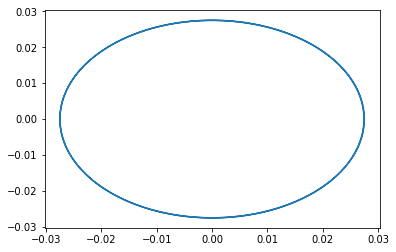

In [61]:
# Plot the image of the Evans function for the first kappa
plt.plot(d.D1.D[:,0].real, d.D1.D[:,0].imag)

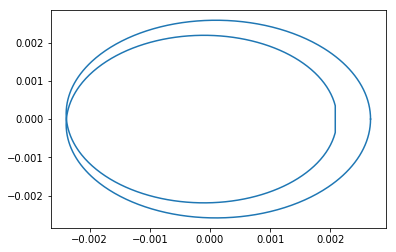

In [62]:
# Plot the image of the Evans function for the first kappa
plt.plot(d.D2.D[:,0].real, d.D2.D[:,0].imag)

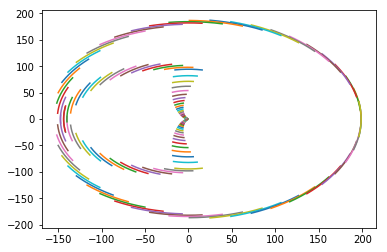

In [69]:
# Plot the image of the Evans function for all kappas
plt.plot(d.D3.D.real, d.D3.D.imag)